In [1]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, truncexpon, truncnorm, nbinom, norm
import pandas as pd
import time
import torch
from torch import nn
from torch import distributions
from torch import rand
from torch import autograd
from torch import optim
import torch.nn as nn

In [2]:
def bij_transform(prime, lower, upper):
    # Recieves a value in [-inf, inf] and returns value in [low, upper]
    bij = 1 / (1 + torch.exp(-prime / upper))
    scale = upper - lower
    return scale * bij + lower


def bij_transform_inv(transf, lower, upper):
    return -torch.log(((upper - lower) / (transf - lower) - 1) ** upper)


def bij_transform_inf(prime):
    return torch.exp(prime)

In [3]:
np.random.seed(seed=101)
torch.manual_seed(101)
#torch.use_deterministic_algorithms(True)
dtype = torch.float64
device = torch.device("cpu")

In [4]:
data = pd.read_csv('covid19model.csv')
#toy_data = pd.read_csv('data/toy_data_2.csv')
#toy_data_np = toy_data['0'].round()
#plt.plot(toy_data_np)

Initialization

In [5]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_impute = 6
#observed_daily_hospit = torch.tensor(toy_data_np, requires_grad=False, device=device, dtype=dtype)
observed_daily_hospit = torch.tensor(data.hospit, requires_grad=False, device=device, dtype=dtype)
pi = torch.tensor(data.delay_distr, requires_grad=False, device=device, dtype=dtype)
serial_interval = torch.tensor(data.serial_interval, requires_grad=False, device=device, dtype=dtype)
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)
num_observations = len(observed_daily_hospit)

R0:3.5735178280523288  grad:58.962831945308345
alpha:0.04999238444077992  grad:1.3794266191884192
phi:3.9966734785299414  grad:75.62269838233688
sigma:0.43464596280665774  grad:97.10400015769153
epsilon_t.mean:-0.032977864146232605  grad.mean:3.4600212574005127
tau:24.90594771373643

In [6]:
tau_prime = torch.tensor(bij_transform_inv(torch.tensor(30), 0, 100), requires_grad=True, device=device, dtype=dtype)  # 33
R0_prime = torch.tensor(bij_transform_inv(torch.tensor(3.57), 2, 5), requires_grad=True, device=device, dtype=dtype)   # 3.6
phi_prime = torch.tensor(bij_transform_inv(torch.tensor(10), 0, 50), requires_grad=True, device=device, dtype=dtype)  # 25
alpha_prime = torch.tensor(bij_transform_inv(torch.tensor(0.049), 0.00001, 0.05), requires_grad=True, device=device, dtype=dtype)  # 0.01
sigma_prime = torch.tensor(bij_transform_inv(torch.tensor(0.43), 0.00001, 0.5), requires_grad=True, device=device, dtype=dtype)  # 0.1
sigma = bij_transform(sigma_prime, 0.00001, 0.5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy 

In [7]:
epsilon_t = torch.zeros(num_observations, device=device)
epsilon_t[0] = torch.distributions.Normal(cero, sigma.detach()).rsample()
for t in range(1, num_observations):
    epsilon_t[t] = torch.distributions.Normal(epsilon_t[t - 1].detach(), sigma.detach()).rsample()
epsilon_t.requires_grad_(True)

tensor([-0.5979, -0.9485, -1.0863, -0.7690, -1.5230, -1.2636, -1.3719, -1.5599,
        -1.8062, -3.1832, -2.9410, -2.8484, -3.7928, -3.8859, -4.1982, -3.4042,
        -3.2973, -3.1778, -2.4821, -2.5826, -3.1582, -3.1849, -3.3007, -2.9141,
        -2.5703, -2.7906, -2.9702, -2.6050, -1.7515, -2.2975, -1.9115, -1.4540,
        -1.7626, -1.2734, -1.9961, -1.9575, -2.0280, -2.4632, -2.2935, -2.0449,
        -1.4603, -1.6262, -1.8847, -2.5026, -2.4261, -2.8342, -2.8740, -2.3746,
        -2.9161, -2.5632, -2.3392, -2.2992, -1.8712, -2.2916, -1.6750, -1.5971,
        -1.5546, -0.9384, -0.8174, -0.6473, -0.2914, -0.3595, -0.0645,  0.1305,
        -0.0509,  0.1365,  0.3618, -0.3760, -0.9268, -1.7355, -2.3911, -2.4762,
        -2.2545, -2.7237, -2.8320, -3.2256, -3.8567, -3.9583, -3.8872, -3.9009,
        -4.0488, -4.5115, -5.0751, -5.1491, -5.9267, -6.1242, -6.3740, -6.1772,
        -6.4051, -6.7182, -6.1826, -6.0009, -5.9053, -5.9210, -5.2845, -4.7046,
        -5.1763, -4.5480, -4.0743, -3.03

In [8]:
dist_tau = distributions.exponential.Exponential(torch.tensor([1 / 0.03], device=device))

dist_phi = distributions.normal.Normal(loc=torch.tensor([25], device=device), scale=torch.tensor([10], device=device))

dist_R0 = distributions.normal.Normal(loc=torch.tensor([3.6], device=device), scale=torch.tensor([0.8], device=device))

dist_alpha = distributions.normal.Normal(loc=torch.tensor([0.01], device=device),
                                         scale=torch.tensor([0.01], device=device))

dist_sigma = distributions.normal.Normal(loc=torch.tensor([0.1], device=device),
                                         scale=torch.tensor([0.3], device=device))

Forward Pass

In [9]:
def calc_prior_loss(tau, phi, R0, alpha, sigma):
    # log likelihood wrt. our prior ("regularisation")
    # ll stands for log-likelihood
    ll = torch.tensor(0.0, device=device)

    ll += dist_tau.log_prob(tau)[0]  # TODO

    ll += dist_phi.log_prob(phi)[0]

    ll += dist_R0.log_prob(R0)[0]

    ll += dist_alpha.log_prob(alpha)[0]

    ll += dist_sigma.log_prob(sigma)[0]

    return -ll

In [10]:
def seed_init_infect(y):
    # Initialize newly_infected, cumulative_infected, St
    newly_infected = torch.zeros(num_observations, device=device, dtype=dtype)  # number of newly infected
    cumulative_infected = torch.zeros(num_observations, device=device)  # cumulative number of infected

    St = torch.zeros(num_observations, device=device)  # fraction of susceptible population
    # seed initial infection / impute first num_impute days
    newly_infected[0:num_impute] = y.clone()
    cumulative_infected[0] = 0.
    cumulative_infected[1:num_impute] = torch.cumsum(newly_infected[0:num_impute - 1].clone(), dim=0)
    St[0:num_impute] = torch.tensor([torch.maximum(population.clone() - x, torch.tensor(0)) / population for x in
                                     cumulative_infected[0:num_impute].clone()])
    return newly_infected, cumulative_infected, St

In [11]:
def calc_Rt(R0, epsilon_t, sigma, ll):
    # Initialize eta_t
    eta_t = torch.zeros(num_observations, device=device)  # transformed reproduction number
    # calculate Rt: the basic reproduction number
    # basic reproduction number as a latent random walk
    beta_0 = torch.log(R0)
    eta_t[0] = beta_0

    # for t in range(1, num_observations):
    #    dist_epsilon_t = torch.distributions.Normal(epsilon_t[t - 1], sigma)
    #    ll += dist_epsilon_t.log_prob(epsilon_t[t])

    loc = epsilon_t[:-1].clone()
    scale = sigma * torch.ones(num_observations - 1)
    mvn = distributions.multivariate_normal.MultivariateNormal(loc, scale_tril=torch.diag(scale))
    ll += mvn.log_prob(epsilon_t[1:].clone())

    eta_t[1:num_observations] = epsilon_t[0:num_observations - 1].clone() + beta_0
    Rt = torch.exp(eta_t)
    ll = (-1) * ll
    return Rt, ll

In [12]:
def calc_infections(cumulative_infected, newly_infected, St, Rt):
    # Initialize effectively_infectious
    effectively_infectious = torch.zeros(num_observations, device=device)  # effective number of infectious individuals

    # calculate infections
    for t in range(num_impute, num_observations):
        # Update cumulative newly_infected
        cumulative_infected[t] = cumulative_infected[t - 1].clone() + newly_infected[t - 1].clone()
        # Adjusts for portion of pop that are susceptible
        St[t] = torch.maximum(population.clone() - cumulative_infected[t].clone(), cero) / population.clone()
        # effective number of infectous individuals
        ni_temp = newly_infected[:t].view(1, 1, -1).clone()
        si_temp = torch.flip(serial_interval, (0,))[-t:].view(1, 1, -1)
        effectively_infectious[t] = torch.nn.functional.conv1d(ni_temp, si_temp)

        newly_infected[t] = St[t].clone() * Rt[t].clone() * effectively_infectious[t].clone()
    return newly_infected

In [13]:
def calc_hospit(newly_infected, alpha):
    # Initialize expected_daily_hospit
    expected_daily_hospit = torch.zeros(num_observations, device=device)  # expected number of daily hospitalizations

    # calculate expected number of hospitalizations
    expected_daily_hospit[0] = (1e-15) * newly_infected[0].clone()
    for t in range(1, num_observations):
        ni_temp = newly_infected[:t].view(1, 1, -1)
        pi_temp = torch.flip(pi, (0,))[-t - 1:-1].view(1, 1, -1)
        expected_daily_hospit[t] = torch.nn.functional.conv1d(ni_temp, pi_temp)
    expected_daily_hospit = alpha * expected_daily_hospit
    return expected_daily_hospit

In [14]:
def compare_results(expected_daily_hospit, phi, ll):
    # compare observed hospitalizations to model results
    # likelihood of the data wrt. to the model

    for i in range(0, num_observations):
        p = 1 / (1 + expected_daily_hospit[i] / phi)
        if p == 1:
            p = p.clone() - torch.tensor(2.225e-5)
        if p < 2.225e-5:
            p = p.clone() + torch.tensor(2.225e-5)
        dist = torch.distributions.negative_binomial.NegativeBinomial(phi, p - torch.tensor(2.225e-5))
        ll += dist.log_prob(observed_daily_hospit[i])

    ll = (-1) * ll
    return ll

In [15]:
def compare_results_abs(expected_daily_hospit, phi, ll):
    # compare observed hospitalizations to model results
    # likelihood of the data wrt. to the model

    diff = expected_daily_hospit - observed_daily_hospit
    square = diff.square()
    msr = square.mean()
    ll += msr


    return ll

In [16]:
def forward_pass():
    # Initialize y
    tau = bij_transform(tau_prime, 0, 100)
    y = torch.distributions.exponential.Exponential(1 / tau).rsample()
    R0 = bij_transform(R0_prime, lower=2, upper=5)
    phi = bij_transform(phi_prime, lower=0.00001, upper=50)
    alpha = bij_transform(alpha_prime, lower=0.00001, upper=0.05)
    sigma = bij_transform(sigma_prime, lower=0.00001, upper=0.5)

    # Calculate prior loss
    ll_prior = calc_prior_loss(tau, phi, R0, alpha, sigma)

    # Seed initial infections
    newly_infected, cumulative_infected, St = seed_init_infect(y)

    # Calculate Rt & random walk loss
    Rt, ll_rw = calc_Rt(R0, epsilon_t, sigma, torch.tensor(0.0, device=device))  ##ll

    # Calculate infections
    newly_infected = calc_infections(cumulative_infected, newly_infected, St, Rt)

    # Calculate expected hospitalizations
    expected_daily_hospit = calc_hospit(newly_infected, alpha)


    # Compare observed hospitalizations to model results
    ll_comp = compare_results(expected_daily_hospit, phi, torch.tensor(0.0, device=device))  ##ll

    return expected_daily_hospit, Rt, ll_prior, ll_rw, ll_comp, tau, R0, phi, alpha, sigma


Optimization


Prior Loss:973.2487182617188  Random Walk Loss:0.22998046875 Comparison Loss:29621.123046875 


Time Step: 0 || Loss: 30594.6015625 || Learning Rate: 0.1

R0:3.4343744334470516  grad:671.7934285741896
alpha:1.0000007704901278e-05  grad:-0.0034018575175598278
phi:9.296663861423  grad:502.86095584893087
sigma:0.2399632641294514  grad:-7.126119740199652
epsilon_t.mean:-1.1739413738250732  grad.mean:37.866477966308594
tau:29.248411427962267  grad:8.86146554893725

This Run:  0.4765012264251709 seconds


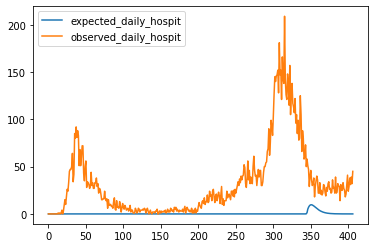

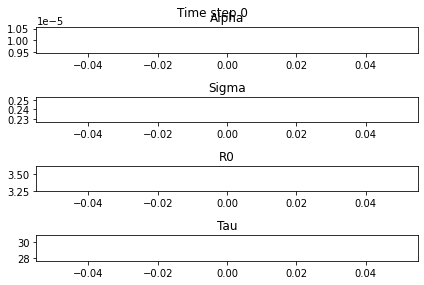


Prior Loss:960.4761962890625  Random Walk Loss:-83.5716552734375 Comparison Loss:28407.345703125 


Time Step: 25 || Loss: 29284.25 || Learning Rate: 0.1

R0:3.387873222068815  grad:-176.55441614480316
alpha:1.0695479418355141e-05  grad:-274.9226929246652
phi:8.926114368437343  grad:485.85836569356013
sigma:0.1970761025015659  grad:0.8625424070726624
epsilon_t.mean:-1.420430302619934  grad.mean:-9.849903106689453
tau:28.864751915045932  grad:5.8146743198727755

This Run:  0.49266934394836426 seconds

Prior Loss:948.46337890625  Random Walk Loss:-153.903076171875 Comparison Loss:27274.001953125 


Time Step: 50 || Loss: 28068.5625 || Learning Rate: 0.1

R0:3.421899975901132  grad:128.80734794217548
alpha:1.0108396650136871e-05  grad:19.829500582155195
phi:8.571269813441221  grad:455.7793710807377
sigma:0.16600252474848276  grad:2.6120554110153926
epsilon_t.mean:-1.2052572965621948  grad.mean:7.241717338562012
tau:28.50379191559736  grad:6.666810028575083

This Run:  0.5147449970245361 

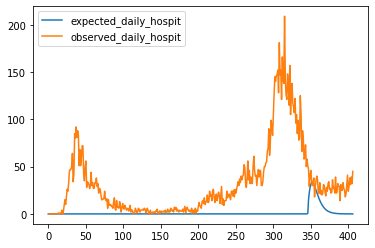


Prior Loss:934.95556640625  Random Walk Loss:-252.97601318359375 Comparison Loss:26160.224609375 


Time Step: 75 || Loss: 26842.203125 || Learning Rate: 0.1

R0:3.461364037577571  grad:-53.789918564925266
alpha:1.000932440703444e-05  grad:-3.530208636810908
phi:8.232021006702725  grad:452.10640900845436
sigma:0.12969031231754077  grad:-0.6271064521681325
epsilon_t.mean:-0.9254691004753113  grad.mean:-3.0499205589294434
tau:28.097742165804057  grad:6.383639788416673

This Run:  0.5030124187469482 seconds

Prior Loss:920.0098266601562  Random Walk Loss:-323.975341796875 Comparison Loss:25089.044921875 


Time Step: 100 || Loss: 25685.080078125 || Learning Rate: 0.1

R0:3.4599934829823975  grad:456.799610110274
alpha:1.0009396468597261e-05  grad:-2.77441919479526
phi:7.906628776323681  grad:435.5110620366833
sigma:0.11000629567672417  grad:12.29159200270118
epsilon_t.mean:-0.9090094566345215  grad.mean:25.909290313720703
tau:27.64783623378058  grad:8.01091621864223

This Run:  0.5136928

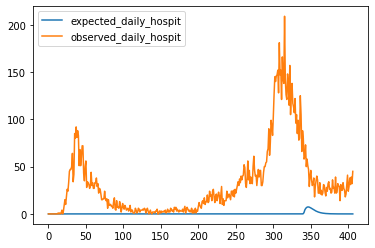


Prior Loss:903.5587768554688  Random Walk Loss:-311.588623046875 Comparison Loss:24017.88671875 


Time Step: 125 || Loss: 24609.857421875 || Learning Rate: 0.1

R0:3.3609694520698206  grad:-170.98143140643134
alpha:1.001134421195804e-05  grad:-4.876843373783
phi:7.598998142413129  grad:421.72223994688136
sigma:0.1130036118474141  grad:7.645069921641599
epsilon_t.mean:-1.491406798362732  grad.mean:-9.491477012634277
tau:27.151825513335737  grad:5.118943701449136

This Run:  0.49642014503479004 seconds

Prior Loss:888.0848388671875  Random Walk Loss:-325.7679443359375 Comparison Loss:23468.892578125 


Time Step: 150 || Loss: 24031.208984375 || Learning Rate: 0.1

R0:3.2731772575028177  grad:-296.82872517761814
alpha:1.0012202352265117e-05  grad:-4.142630689480922
phi:7.308083626350634  grad:416.0227906125623
sigma:0.11025433452925246  grad:20.724429322778168
epsilon_t.mean:-1.9849790334701538  grad.mean:-16.28268814086914
tau:26.6849197247019  grad:5.388793321747171

This Run:  0.5185

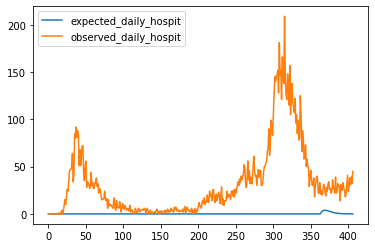


Prior Loss:874.3536376953125  Random Walk Loss:-377.2388916015625 Comparison Loss:22450.537109375 


Time Step: 175 || Loss: 22947.65234375 || Learning Rate: 0.1

R0:3.281433605356697  grad:109.34471604167939
alpha:1.0012391961604697e-05  grad:1.3516788009815266
phi:7.029992385406612  grad:391.71234240034994
sigma:0.09363678409862496  grad:-26.714322841591024
epsilon_t.mean:-1.9243903160095215  grad.mean:6.008774757385254
tau:26.271632157200347  grad:6.720255512802549

This Run:  0.4983212947845459 seconds

Prior Loss:860.8814697265625  Random Walk Loss:-409.30364990234375 Comparison Loss:21507.337890625 


Time Step: 200 || Loss: 21958.916015625 || Learning Rate: 0.1

R0:3.30627306093111  grad:97.7725534119939
alpha:1.0011892844183104e-05  grad:-0.03909614606669936
phi:6.766738807674776  grad:377.6120987496293
sigma:0.08739789315051329  grad:-13.699867416248779
epsilon_t.mean:-1.7704124450683594  grad.mean:5.3885979652404785
tau:25.866374165401524  grad:6.3538948766386785

This Run: 

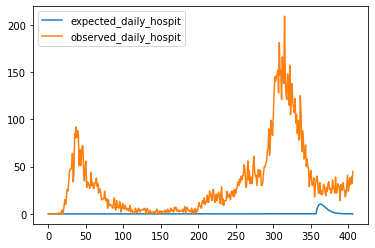


Prior Loss:846.9583129882812  Random Walk Loss:-480.91998291015625 Comparison Loss:20704.115234375 


Time Step: 225 || Loss: 21070.154296875 || Learning Rate: 0.1

R0:3.302318730099695  grad:113.93896045096854
alpha:1.001046969371787e-05  grad:0.3744663368352812
phi:6.51799837326216  grad:363.95282228051315
sigma:0.07321818717430278  grad:-15.062875401616653
epsilon_t.mean:-1.7708697319030762  grad.mean:6.275897979736328
tau:25.44716211943454  grad:6.310711392548856

This Run:  0.5115408897399902 seconds

Prior Loss:833.3742065429688  Random Walk Loss:-514.0579833984375 Comparison Loss:19950.6796875 


Time Step: 250 || Loss: 20269.99609375 || Learning Rate: 0.1

R0:3.3173734995081103  grad:-675.7493149823798
alpha:1.0009976710016517e-05  grad:2.4040181145054413
phi:6.280414622807544  grad:347.73259090370016
sigma:0.06824238120231475  grad:0.5214120295117516
epsilon_t.mean:-1.6730022430419922  grad.mean:-37.268184661865234
tau:25.038468689624914  grad:3.8944241939650137

This Run:  0

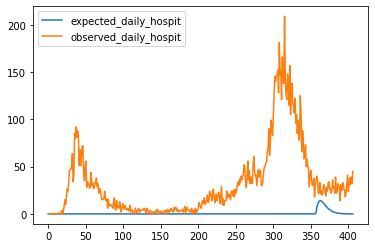


Prior Loss:819.7000732421875  Random Walk Loss:-546.6636962890625 Comparison Loss:19314.72265625 


Time Step: 275 || Loss: 19587.7578125 || Learning Rate: 0.1

R0:3.318995707662368  grad:92.63705238554255
alpha:1.0009500185818313e-05  grad:4.154724993556067
phi:6.054546117268695  grad:332.7413817958617
sigma:0.06286149767109808  grad:-2.0619028330321925
epsilon_t.mean:-1.6401162147521973  grad.mean:5.114229679107666
tau:24.6269261114982  grad:6.313873049506167

This Run:  0.5062081813812256 seconds

Prior Loss:806.2529907226562  Random Walk Loss:-581.7318115234375 Comparison Loss:18541.45703125 


Time Step: 300 || Loss: 18765.978515625 || Learning Rate: 0.1

R0:3.3237619535966347  grad:239.59569377271842
alpha:1.0009216362708887e-05  grad:2.1798865347136394
phi:5.8391221714175146  grad:324.0867525114659
sigma:0.05766656239310171  grad:-1.917839083594859
epsilon_t.mean:-1.5941749811172485  grad.mean:13.230490684509277
tau:24.222278069867436  grad:6.603905252750328

This Run:  0.51602

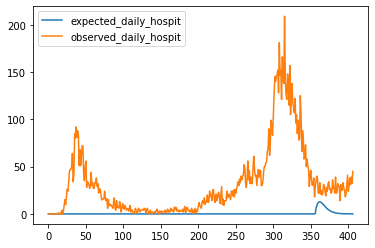


Prior Loss:793.051513671875  Random Walk Loss:-610.470458984375 Comparison Loss:17839.353515625 


Time Step: 325 || Loss: 18021.93359375 || Learning Rate: 0.1

R0:3.3297465102638033  grad:97.12290946428718
alpha:1.0008528668482089e-05  grad:0.7282274152563082
phi:5.634941371394901  grad:316.4361449456287
sigma:0.054185993958346265  grad:10.415159383996729
epsilon_t.mean:-1.5492174625396729  grad.mean:5.369797229766846
tau:23.825078505720207  grad:6.298995261304124

This Run:  0.47595882415771484 seconds

Prior Loss:779.9728393554688  Random Walk Loss:-639.638916015625 Comparison Loss:17195.4921875 


Time Step: 350 || Loss: 17335.826171875 || Learning Rate: 0.1

R0:3.3382572601056433  grad:177.78882682667975
alpha:1.0007889068532553e-05  grad:1.1151752159208062
phi:5.440327577995231  grad:301.64683790574446
sigma:0.050089917792754075  grad:0.634579253792771
epsilon_t.mean:-1.476601481437683  grad.mean:9.839335441589355
tau:23.43162398911242  grad:5.8784842361577345

This Run:  0.5193

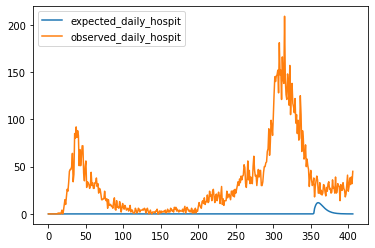


Prior Loss:767.1409912109375  Random Walk Loss:-681.5629272460938 Comparison Loss:16677.001953125 


Time Step: 375 || Loss: 16762.580078125 || Learning Rate: 0.1

R0:3.352347800571211  grad:186.81691332088957
alpha:1.0007216052186044e-05  grad:2.3536022650888633
phi:5.255206390366773  grad:290.2933164870559
sigma:0.04530855608032042  grad:4.978440754368158
epsilon_t.mean:-1.3785178661346436  grad.mean:10.361956596374512
tau:23.04566029849334  grad:6.360582852936126

This Run:  0.4861009120941162 seconds

Prior Loss:754.2888793945312  Random Walk Loss:-710.75830078125 Comparison Loss:16086.6552734375 


Time Step: 400 || Loss: 16130.185546875 || Learning Rate: 0.1

R0:3.3471631696708433  grad:140.27239314985658
alpha:1.0006640985216662e-05  grad:1.6545663286375984
phi:5.078748759064554  grad:282.1996449655502
sigma:0.04233830001402047  grad:11.113851754500612
epsilon_t.mean:-1.3854241371154785  grad.mean:7.774585723876953
tau:22.658932033440614  grad:6.1841883552811625

This Run:  0.5

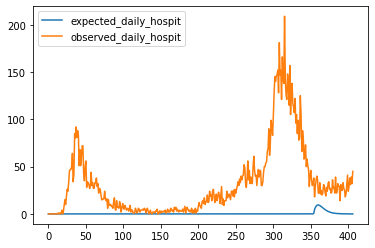


Prior Loss:742.3095092773438  Random Walk Loss:-721.675537109375 Comparison Loss:15593.7021484375 


Time Step: 425 || Loss: 15614.3359375 || Learning Rate: 0.1

R0:3.3933492913458756  grad:220.10537423048535
alpha:1.0006109941332565e-05  grad:2.298190864587416
phi:4.910680283695935  grad:269.2511932467442
sigma:0.04070845106565915  grad:-7.289824649437999
epsilon_t.mean:-1.0731350183486938  grad.mean:12.298996925354004
tau:22.29900613151756  grad:6.3350046159025455

This Run:  0.4917902946472168 seconds

Prior Loss:730.4278564453125  Random Walk Loss:-745.5460205078125 Comparison Loss:15156.5673828125 


Time Step: 450 || Loss: 15141.44921875 || Learning Rate: 0.1

R0:3.4208708864890998  grad:-141.8815658101881
alpha:1.0005541523493329e-05  grad:2.161646565501681
phi:4.750956614623713  grad:260.2260050006929
sigma:0.044320803419667716  grad:205.5715213711468
epsilon_t.mean:-0.8988634943962097  grad.mean:-7.9700140953063965
tau:21.941907026817937  grad:4.899155415754908

This Run:  0.

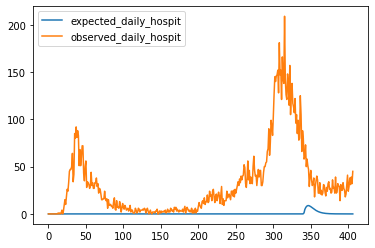


Prior Loss:717.8793334960938  Random Walk Loss:-775.5838623046875 Comparison Loss:14534.12109375 


Time Step: 475 || Loss: 14476.416015625 || Learning Rate: 0.1

R0:3.3969199689591814  grad:-577.8465445877041
alpha:1.000489092259015e-05  grad:0.8365219055214373
phi:4.598545371785491  grad:253.910514008006
sigma:0.034386638106042595  grad:-61.79824850531333
epsilon_t.mean:-1.0273268222808838  grad.mean:-32.30221939086914
tau:21.56410777271601  grad:3.1834556201489783

This Run:  0.4969198703765869 seconds

Prior Loss:705.7401123046875  Random Walk Loss:-805.1534423828125 Comparison Loss:14111.267578125 


Time Step: 500 || Loss: 14011.8544921875 || Learning Rate: 0.1

R0:3.389555310633556  grad:178.05126330980178
alpha:1.0004481514634383e-05  grad:1.0050783482062708
phi:4.452568721446861  grad:246.47790062768038
sigma:0.03442970723641835  grad:50.203931892745814
epsilon_t.mean:-1.0393519401550293  grad.mean:9.9422025680542
tau:21.19896571949271  grad:5.9366034749358825

This Run:  0.5

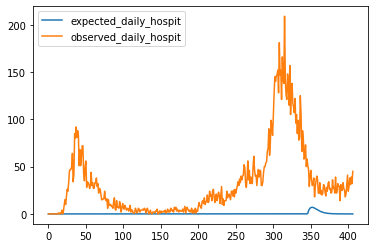

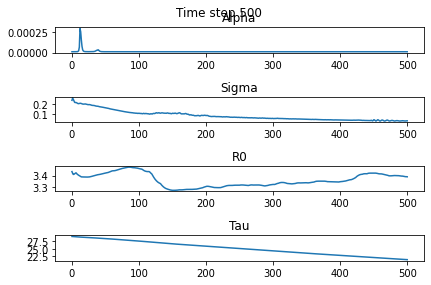


Prior Loss:693.6326293945312  Random Walk Loss:-804.8433837890625 Comparison Loss:13653.9853515625 


Time Step: 525 || Loss: 13542.7744140625 || Learning Rate: 0.1

R0:3.3670973642418893  grad:186.97192835986073
alpha:1.0004084549451907e-05  grad:0.7225025043644986
phi:4.313113542601316  grad:238.63102062995213
sigma:0.03326180659164254  grad:-3.128816486349715
epsilon_t.mean:-1.1411665678024292  grad.mean:10.396687507629395
tau:20.834619738445845  grad:5.6153391619821

This Run:  0.4899177551269531 seconds

Prior Loss:682.55712890625  Random Walk Loss:-827.641845703125 Comparison Loss:13429.25 


Time Step: 550 || Loss: 13284.166015625 || Learning Rate: 0.1

R0:3.4199585281362026  grad:-766.5543523501701
alpha:1.000361432007669e-05  grad:1.5731024911580662
phi:4.180408663131443  grad:229.13001819898363
sigma:0.031651005824032345  grad:6.767602512126686
epsilon_t.mean:-0.8019957542419434  grad.mean:-43.06184768676758
tau:20.502001903627683  grad:2.721262908604906

This Run:  0.496956

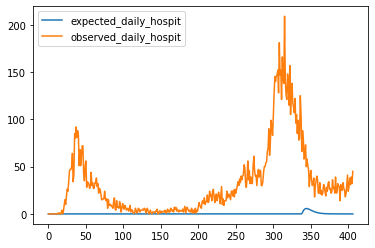


Prior Loss:671.81298828125  Random Walk Loss:-848.7216796875 Comparison Loss:13538.33203125 


Time Step: 575 || Loss: 13361.423828125 || Learning Rate: 0.1

R0:3.4651807412783375  grad:725.1869910273564
alpha:1.0002859362282432e-05  grad:2.7446724237652336
phi:4.054788507713611  grad:218.86349406182563
sigma:0.02945508931574718  grad:-23.727939229423857
epsilon_t.mean:-0.49220648407936096  grad.mean:41.185394287109375
tau:20.179174961529014  grad:7.551478286439036

This Run:  0.48949646949768066 seconds

Prior Loss:662.54833984375  Random Walk Loss:-777.9436645507812 Comparison Loss:10540.4248046875 


Time Step: 600 || Loss: 10425.029296875 || Learning Rate: 0.1

R0:3.580763989023411  grad:-228.91332157271418
alpha:1.0002009455346432e-05  grad:-0.6084564594074222
phi:3.939836529087467  grad:182.87892948222066
sigma:0.03452183249609835  grad:-47.06368376175472
epsilon_t.mean:0.4701780378818512  grad.mean:-13.465217590332031
tau:19.90104303100697  grad:1.6210094951845933

This Run:  0

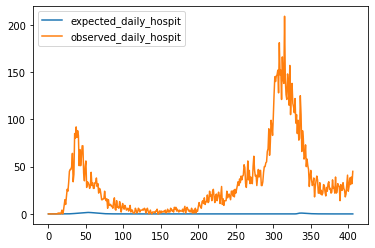


Prior Loss:651.8499145507812  Random Walk Loss:-700.712158203125 Comparison Loss:7689.63330078125 


Time Step: 625 || Loss: 7640.77099609375 || Learning Rate: 0.1

R0:3.5722348432488946  grad:-552.6060424531403
alpha:1.0002408345754747e-05  grad:-4.449355175059652
phi:3.8441147984142967  grad:148.55783681798053
sigma:0.04618633453181631  grad:102.75406052753831
epsilon_t.mean:0.550702691078186  grad.mean:-32.40956497192383
tau:19.579706532166863  grad:-0.5150458817682102

This Run:  0.49311184883117676 seconds

Prior Loss:642.5584716796875  Random Walk Loss:-725.988037109375 Comparison Loss:5771.54833984375 


Time Step: 650 || Loss: 5688.119140625 || Learning Rate: 0.1

R0:3.5740573033063465  grad:-158.50366779381977
alpha:1.000360770045926e-05  grad:-6.163814371648808
phi:3.7573639513101464  grad:111.37011233595635
sigma:0.040562144622992326  grad:3.1821009223091514
epsilon_t.mean:0.5791135430335999  grad.mean:-9.301616668701172
tau:19.300307263190668  grad:2.339958828121111

This 

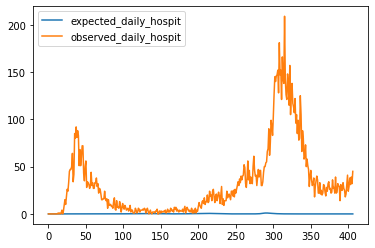


Prior Loss:632.21337890625  Random Walk Loss:-768.9769897460938 Comparison Loss:5851.1748046875 


Time Step: 675 || Loss: 5714.4111328125 || Learning Rate: 0.1

R0:3.5782319021949567  grad:452.5914549894834
alpha:1.000933777122865e-05  grad:-16.392308642006846
phi:3.6873450580689733  grad:113.92484944315862
sigma:0.035574288797222534  grad:-34.97703845800311
epsilon_t.mean:0.6300575733184814  grad.mean:26.599714279174805
tau:18.98940866696062  grad:6.507257168414036

This Run:  0.4610939025878906 seconds

Prior Loss:624.1787719726562  Random Walk Loss:-760.083740234375 Comparison Loss:6901.55224609375 


Time Step: 700 || Loss: 6765.6474609375 || Learning Rate: 0.1

R0:3.5788665766548635  grad:113.85795676104442
alpha:1.052970598334166e-05  grad:-693.6918325597859
phi:3.6238922680197705  grad:129.03853124272243
sigma:0.03532961122085448  grad:-78.45810145377047
epsilon_t.mean:0.6306189298629761  grad.mean:6.693362236022949
tau:18.747959439571606  grad:10.45962034740558

This Run:  0.

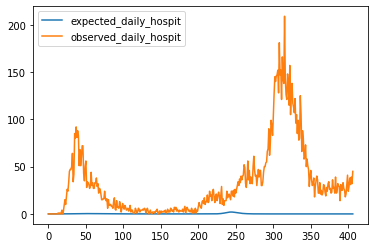


Prior Loss:614.2025756835938  Random Walk Loss:-722.7019653320312 Comparison Loss:6635.56298828125 


Time Step: 725 || Loss: 6527.0634765625 || Learning Rate: 0.1

R0:3.570417028429335  grad:-59.540028785577135
alpha:1.0000000000000062e-05  grad:-9.629097616901551e-11
phi:3.559969236667485  grad:128.5796066321727
sigma:0.039819647640231944  grad:-36.51388631801407
epsilon_t.mean:0.6494000554084778  grad.mean:-3.489393949508667
tau:18.448347673721287  grad:4.3697779038318725

This Run:  0.48734068870544434 seconds

Prior Loss:605.889404296875  Random Walk Loss:-755.9010009765625 Comparison Loss:5807.6953125 


Time Step: 750 || Loss: 5657.68359375 || Learning Rate: 0.1

R0:3.6002488492488363  grad:183.10887661598665
alpha:1.0000000000000008e-05  grad:-8.726745389494193e-12
phi:3.4920916769829167  grad:107.01656575602314
sigma:0.0373684834772658  grad:-9.308209369408855
epsilon_t.mean:0.7751209139823914  grad.mean:10.846766471862793
tau:18.19848502457137  grad:8.011369294638794

This R

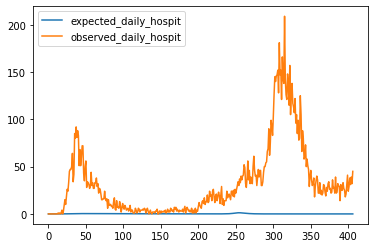


Prior Loss:596.67626953125  Random Walk Loss:-775.563232421875 Comparison Loss:3791.436279296875 


Time Step: 775 || Loss: 3612.54931640625 || Learning Rate: 0.1

R0:3.5871381959691617  grad:35.809969020973384
alpha:1.0000000000000006e-05  grad:-1.0009069592762021e-11
phi:3.4305202542861926  grad:72.63852818374589
sigma:0.03460419144054975  grad:-52.31625928375562
epsilon_t.mean:0.733421802520752  grad.mean:2.1114017963409424
tau:17.92163140537322  grad:7.024474372794925

This Run:  0.49924659729003906 seconds

Prior Loss:588.0902709960938  Random Walk Loss:-772.5946044921875 Comparison Loss:4224.64453125 


Time Step: 800 || Loss: 4040.14013671875 || Learning Rate: 0.1

R0:3.5581463445878767  grad:-209.59062099605194
alpha:1.0000000000000006e-05  grad:-1.1150460936695305e-11
phi:3.3758142237069437  grad:85.83805500511308
sigma:0.03620649209293501  grad:5.01854824694487
epsilon_t.mean:0.6316086649894714  grad.mean:-12.2332763671875
tau:17.663694663856134  grad:5.061534913538236

This

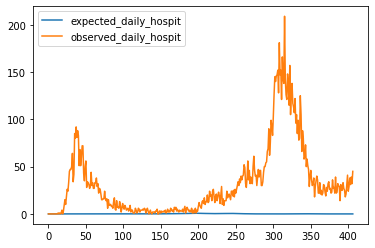


Prior Loss:579.1229248046875  Random Walk Loss:-784.5346069335938 Comparison Loss:5448.30908203125 


Time Step: 825 || Loss: 5242.8974609375 || Learning Rate: 0.1

R0:3.5493147314282387  grad:-569.5466024175641
alpha:1.0000000000000006e-05  grad:-1.0536394512663328e-11
phi:3.3244402288262824  grad:107.55946832419743
sigma:0.03555235728174731  grad:21.88296760357133
epsilon_t.mean:0.6495568156242371  grad.mean:-33.14734649658203
tau:17.394307105594365  grad:-1.5289853020503998

This Run:  0.48634791374206543 seconds

Prior Loss:572.3604125976562  Random Walk Loss:-789.9520263671875 Comparison Loss:3458.189453125 


Time Step: 850 || Loss: 3240.59765625 || Learning Rate: 0.1

R0:3.5610033375488603  grad:24.738094316597177
alpha:1.0000000000000006e-05  grad:-1.050335468217572e-11
phi:3.2699764593952256  grad:69.2866858296406
sigma:0.03502478162447926  grad:19.480989091258124
epsilon_t.mean:0.6935023665428162  grad.mean:1.445879340171814
tau:17.191090390286266  grad:3.7070575071271095

T

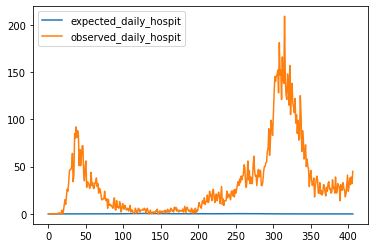


Prior Loss:564.5850830078125  Random Walk Loss:-815.19482421875 Comparison Loss:3886.091796875 


Time Step: 875 || Loss: 3635.48193359375 || Learning Rate: 0.1

R0:3.565263139509516  grad:-162.69765100339617
alpha:1.0000000000000006e-05  grad:-9.40655259241287e-12
phi:3.226743884195441  grad:73.80748233792566
sigma:0.030676422059397128  grad:-87.59646951489115
epsilon_t.mean:0.7182000279426575  grad.mean:-9.518937110900879
tau:16.957459162726003  grad:-1.1178406582412754

This Run:  0.4883580207824707 seconds

Prior Loss:556.6260375976562  Random Walk Loss:-849.0169677734375 Comparison Loss:3090.271240234375 


Time Step: 900 || Loss: 2797.88037109375 || Learning Rate: 0.1

R0:3.5535856373897428  grad:-92.35120043293588
alpha:1.0000000000000006e-05  grad:-9.677308894192938e-12
phi:3.188487118985942  grad:59.504849602420144
sigma:0.03256050756606779  grad:129.66277274626444
epsilon_t.mean:0.7012598514556885  grad.mean:-5.381794452667236
tau:16.718458184553008  grad:3.508662545030719



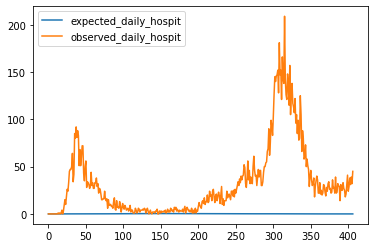

In [ ]:
# Visualization initialization
alpha_vis = []
sigma_vis = []
R0_vis = []
tau_vis = []
phi_vis = []
epsilon_mean_vis = []
loss_vis = []
prior_loss_vis = []
rw_loss_vis = []
comp_loss_vis = []
learning_rate_vis = []

learning_rate = 1e-1
epochs = 1000
complete_time = time.time()

var_list = [tau_prime, phi_prime, R0_prime, alpha_prime, sigma_prime, epsilon_t]
optimizer = optim.Adam(var_list, lr=learning_rate)

for k in range(epochs):
    optimizer.zero_grad()
    start_time = time.time()
    #decay = (1 - (k / (epochs * 1000))) ** 2
    #learning_rate = learning_rate * decay

    # forward pass - calculate expected_daily_hospit
    expected_daily_hospit, Rt, ll_prior, ll_rw, ll_comp, tau, R0, phi, alpha, sigma = forward_pass()

    # backward pass
    loss = ll_comp  + ll_rw + ll_prior

    loss.backward()

    if k % 25 == 0:
        print(
            f'\nPrior Loss:{ll_prior}  Random Walk Loss:{ll_rw} Comparison Loss:{ll_comp} \n'
            f'\n\nTime Step: {k} || Loss: {loss} || Learning Rate: {learning_rate}\n\nR0:{R0}  grad:{R0_prime.grad}\nalpha:{alpha}  grad:{alpha_prime.grad}\n'
            f'phi:{phi}  grad:{phi_prime.grad}\nsigma:{sigma}  grad:{sigma_prime.grad}'
            f'\nepsilon_t.mean:{epsilon_t.mean()}  grad.mean:{epsilon_t.grad.mean()}\ntau:{tau}  grad:{tau_prime.grad}\n')
        print("This Run:  %s seconds" % (time.time() - start_time))
    optimizer.step()

    # Visualization
    alpha_vis.append(alpha.item())
    sigma_vis.append(sigma.item())
    R0_vis.append(R0.item())
    tau_vis.append(tau.item())
    phi_vis.append(phi.item())
    epsilon_mean_vis.append(epsilon_t.abs().mean().item())
    loss_vis.append(loss.item())
    prior_loss_vis.append(ll_prior.item())
    rw_loss_vis.append(ll_rw.item())
    comp_loss_vis.append(ll_comp.item())
    learning_rate_vis.append(learning_rate)

    if k % 50 == 0:
        plt.plot(expected_daily_hospit.cpu().detach().numpy(), label='expected_daily_hospit')
        plt.plot(observed_daily_hospit.cpu().detach().numpy(), label='observed_daily_hospit')
        plt.legend()
        plt.show()

    if k % 500 == 0:
        fig, axs = plt.subplots(4)
        fig.suptitle(f'Time step {k}')
        axs[0].plot(alpha_vis)
        axs[0].title.set_text('Alpha')
        axs[1].plot(sigma_vis)
        axs[1].title.set_text('Sigma')
        axs[2].plot(R0_vis)
        axs[2].title.set_text('R0')
        axs[3].plot(tau_vis)
        axs[3].title.set_text('Tau')
        fig.tight_layout()
        plt.show()

print("Complete Run:  %s seconds" % (time.time() - complete_time))


Evaluate Model

In [ ]:
plt.plot(expected_daily_hospit.cpu().detach().numpy(), label='expected_daily_hospit')
plt.plot(observed_daily_hospit.cpu().detach().numpy(), label='observed_daily_hospit')
plt.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(6)
fig.suptitle(f'Evaluate Values')
fig.set_figheight(10)
axs[0].plot(alpha_vis)
axs[0].title.set_text('Alpha')
axs[1].plot(sigma_vis)
axs[1].title.set_text('Sigma')
axs[2].plot(R0_vis)
axs[2].title.set_text('R0')
axs[3].plot(tau_vis)
axs[3].title.set_text('Tau')
axs[4].plot(phi_vis)
axs[4].title.set_text('Phi')
axs[5].plot(epsilon_mean_vis)
axs[5].title.set_text('Epsilon_Abs_Mean')
plt.show()

In [ ]:
fig, axs = plt.subplots(5)
fig.suptitle(f'Loss Evaluation')
fig.set_figheight(10)
axs[0].plot(loss_vis)
axs[0].title.set_text('Total Loss')
axs[1].plot(prior_loss_vis)
axs[1].title.set_text('Prior Loss')
axs[2].plot(rw_loss_vis)
axs[2].title.set_text('Random Walk Loss')
axs[3].plot(comp_loss_vis)
axs[3].title.set_text('Comparison Loss')
axs[4].plot(learning_rate_vis)
axs[4].title.set_text('Learning Rate')
plt.show()